
<center><img src="https://github.com/insaid2018/Term-1/blob/master/Images/INSAID_Full%20Logo.png?raw=true" width="360" height="160" /></center>

# <center>**Neural Style Transfer**</center>




---
## **Table of Contents**
---

1. [**Problem Statement**](#section1)<br>
2. [**Importing Packages**](#section2)<br>
3. [**Checking the style and content image**](#section3)<br>   
4. [**Fast Style Transfer using TF-Hub**](#section4)<br> 
5. [**Style Transfer using Optimization**](#section5)<br>
6. [**Conclusion**](#section6)<br>
7. [**Application**](#section7)<br>

<a name=section1></a>

---
# **1. Problem Statement**

---

- Neural style transfer is an optimization technique used to take two images — a content image and a style reference image (such as an artwork by a famous painter) — and blend them together so the output image looks like the content image, but **“painted”** in the style of the style reference image.

<center><img src="https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Fbethgelab.org%2Fimages%2Fstyletransfer.jpg&f=1&nofb=1" width=></center>

- This is implemented by optimizing the output image to match the content statistics of the content image and the style statistics of the style reference image.

- These statistics are extracted from the images using a convolutional network.

<a name=section2></a>

---
# **2. Importing Libraries**
---

In [1]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False
import tensorflow_hub as hub
import numpy as np
import PIL.Image
import time
import functools

<a name=section3></a>

---
# **3. Checking the Style and Content Image**
---

In [2]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [3]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

204800/195196 [===============================] - 0s 0us/step


In [4]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

Create a simple function to display an image:

In [5]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

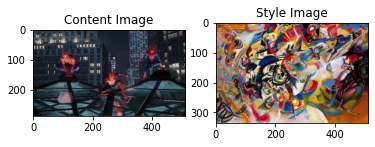

In [7]:
content_image = load_img('/content/the trio.jpg')
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

<a name=section4></a>

---
# **4. Fast Style Transfer using TF-Hub**
---

- Let's see how the [TensorFlow Hub model](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2) works for style transfer:

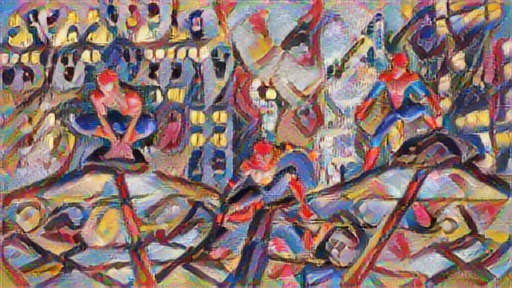

In [8]:
# Loading the model that can apply any arbitrary style to any image
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

# Obtaining the styled image from the model using our content and style images
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]

# Displaying the image
tensor_to_image(stylized_image)

<a name=section5></a>

---
# **5. Style Transfer using Optimization**
---

<a name=section51></a>

---
## **5.1. Obtain a VGG19 model**
---

- Use the intermediate layers of the model to get the *content* and *style* representations of the image.

- Starting from the network's input layer, the first few layer activations represent low-level features like edges and textures.

- As we step through the network, the final few layers represent higher-level features—object parts like *wheels* or *eyes*.

- In this case, we are using the VGG19 network architecture, a pretrained image classification network.

<center><img src="https://prabinnepal.com/wp-content/uploads/2020/09/vggnet.png"></center>

- These intermediate layers are necessary to define the representation of content and style from the images.

- For an input image, try to match the corresponding style and content target representations at these intermediate layers.

- Loading a [**VGG19**](https://keras.io/api/applications/vgg/#vgg19-function) and test runnibg it on our image to ensure it's used correctly:

```
# This is formatted as code
```



In [9]:
# Processing our input image
x = tf.keras.applications.vgg19.preprocess_input(load_img(content_path)*255)
x = tf.image.resize(x, (224, 224))

# Loading the VGG19 model
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')

# Making Predictions using VGG19
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574726144/574710816 [==============================] - 5s 0us/step


TensorShape([1, 1000])

In [10]:
# Taking out the top 5 predictions
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]

# Checking the predictions
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

49152/35363 [=========================================] - 0s 0us/step


[('Labrador_retriever', 0.49317124),
 ('golden_retriever', 0.236653),
 ('kuvasz', 0.036357526),
 ('Chesapeake_Bay_retriever', 0.024182705),
 ('Greater_Swiss_Mountain_dog', 0.018646037)]

<a name=section52></a>

---
## **5.2. Define content and style representations**
---

- First, we will load a `VGG19` without the classification head, and list the layer names

In [11]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()

# Displaying the layers of vgg19
for layer in vgg.layers:
  print(layer.name)

80150528/80134624 [==============================] - 1s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


- Choosing the **intermediate** layers from the network to represent the style and content of the image:


In [12]:
# Assigning the content layer
content_layers = ['block5_conv2'] 

# Assigning the style layers
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

#### Intermediate layers for style and content

- So why do these intermediate outputs within our pretrained image classification network allow us to define style and content representations?

    - At a high level, in order for a network to perform image classification (which this network has been trained to do), it must understand the image.

    - This requires taking the raw image as input pixels and building an internal representation that converts the raw image pixels into a complex understanding of the features present within the image.

    - This is also a reason why convolutional neural networks are able to generalize well: they’re able to capture the invariances and defining features within classes (e.g. cats vs. dogs) that are agnostic to background noise and other nuisances.

    - Thus, somewhere between where the raw image is fed into the model and the output classification label, the model serves as a complex feature extractor.
     
    - By accessing intermediate layers of the model, you're able to describe the content and style of input images.

<a name=section53></a>

---
## **5.3 Build the model**
---

- The networks in `tf.keras.applications` are designed so you can easily extract the intermediate layer values using the Keras functional API.

- To define a model using the functional API, specify the inputs and outputs:

        model = Model(inputs, outputs)

- This following function builds a VGG19 model that returns a list of intermediate layer outputs:

In [13]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

And to create the model:

In [14]:
# Style Extraction Layers
style_extractor = vgg_layers(style_layers)

# Output that learns the style
style_outputs = style_extractor(style_image*255)

# Looking at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  835.5256
  mean:  33.97525

block2_conv1
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  4625.887
  mean:  199.82687

block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  8789.237
  mean:  230.78099

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  21566.14
  mean:  791.24005

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3189.2537
  mean:  59.179485



<a name=section54></a>

---
## **5.4 Calculate and Extract style**
---

- The content of an image is represented by the values of the intermediate feature maps.

- It turns out, the style of an image can be described by the means and correlations across the different feature maps.

- Calculate a **[Gram matrix](https://cloudxlab.com/assessment/displayslide/5648/calculating-style)** that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations.

- This Gram matrix can be calculated for a particular layer as:

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

- This can be implemented concisely using the [`tf.linalg.einsum`](https://www.tensorflow.org/api_docs/python/tf/einsum) function:

In [15]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

### Extract style and content:

- Build a model that returns the style and content tensors.


In [16]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    # Preparing the model
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False
  
  # Creating a call function
  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)

    # Extracting the style and content layers from our model
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    # Calculating gram-matrix for style image
    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]
    
    # Storing the content information
    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}
    
    # Storing the style information
    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

- When called on an image, this model returns the gram matrix (style) of the `style_layers` and content of the `content_layers`:

In [17]:
# Creating a StyleContentModel object using our style and content layers 
extractor = StyleContentModel(style_layers, content_layers)

# Extracting the style and content details of an image
results = extractor(tf.constant(content_image))

# Displaying style and content information
print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.018021442
    max:  34370.242
    mean:  724.63306

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  177504.5
    mean:  22947.527

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  580676.4
    mean:  25311.078

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  8379834.0
    mean:  420031.38

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  163981.02
    mean:  3609.857

Contents:
   block5_conv2
    shape:  (1, 18, 32, 512)
    min:  0.0
    max:  1620.0046
    mean:  24.05012


<a name=section55></a>

---
## **5.5 Run Optimization**
---

- With this style and content extractor, you can now implement the style transfer algorithm.

- Do this by calculating the mean square error for your image's output relative to each target, then take the weighted sum of these losses.

- Set your style and content target values:

In [18]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

- Define a `tf.Variable` to contain the image to optimize.

- To make this quick, initialize it with the content image (the `tf.Variable` must be the same shape as the content image):

In [19]:
image = tf.Variable(content_image)

- Since this is a float image, define a function to keep the pixel values between 0 and 1:

In [20]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

- Create an optimizer. The paper recommends LBFGS, but `Adam` works okay, too:

In [21]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

- To optimize this, use a weighted combination of the two losses to get the total loss:

In [22]:
style_weight=1e-2
content_weight=1e4

In [23]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    # Calculating style loss
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    # Calculating content loss
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers

    # Overall Loss
    loss = style_loss + content_loss
    return loss

- Use [`tf.GradientTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape) to update the image.

In [24]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

- Now run a few steps to test:

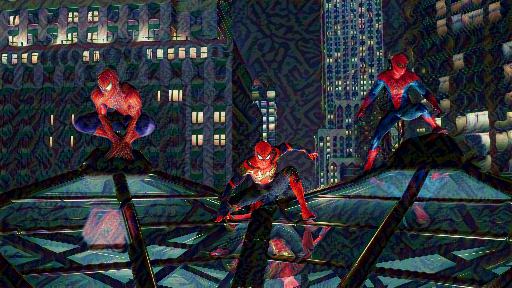

In [25]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

- Since it's working, perform a **longer optimization**:

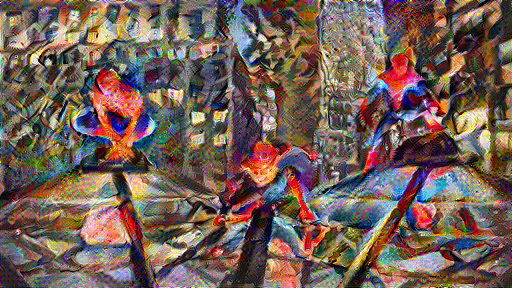

Train step: 3000
Total time: 554.5


In [26]:
import time
start = time.time()

epochs = 30
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

<a name=section56></a>

---
## **5.6 Total variation loss**
---

- One downside to this basic implementation is that it produces a lot of high frequency artifacts.

- Decrease these using an explicit regularization term on the high frequency components of the image.

- In style transfer, this is often called the ***total variation loss***:

In [27]:
# Helper function for removing high frequency components
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

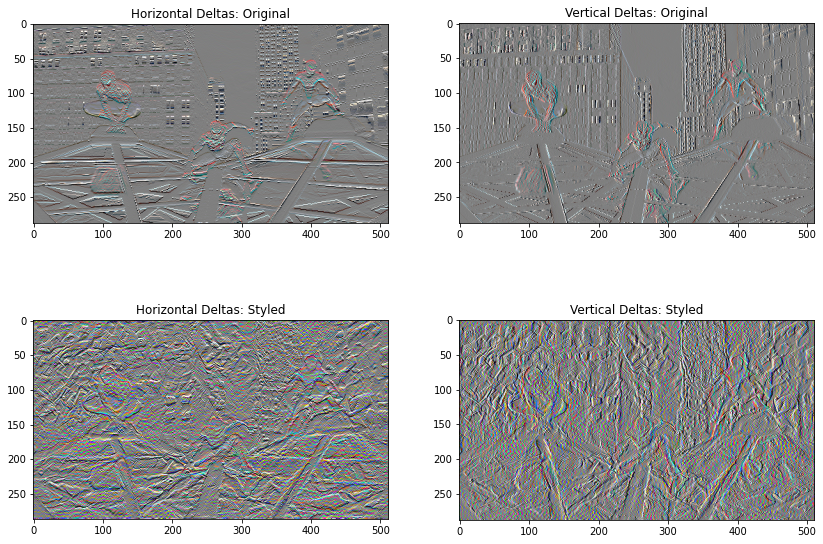

In [28]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

- This shows how the high frequency components have increased.

- Also, this high frequency component is basically an edge-detector. You can get similar output from the [**Sobel edge detector**](https://www.imageeprocessing.com/2011/12/sobel-edge-detection.html), for example:

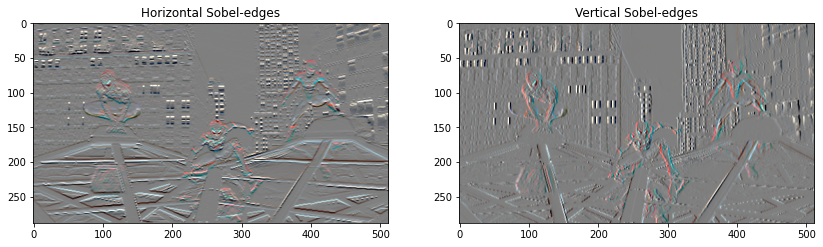

In [29]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

- The regularization loss associated with this is the sum of the squares of the values:

In [30]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [31]:
total_variation_loss(image).numpy()

104323.63

- That demonstrated what it does. But there's no need to implement it yourself, TensorFlow includes a standard implementation:

In [32]:
tf.image.total_variation(image).numpy()

array([104323.63], dtype=float32)

<a name=section57></a>

---
## **5.7 Re-run the optimization**
---

- Choose a weight for the `total_variation_loss`:

In [33]:
total_variation_weight=30

- Now include it in the `train_step` function:

In [34]:
# Updated train step
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

- Reinitialize the optimization variable:

In [35]:
image = tf.Variable(content_image)

- And run the optimization:

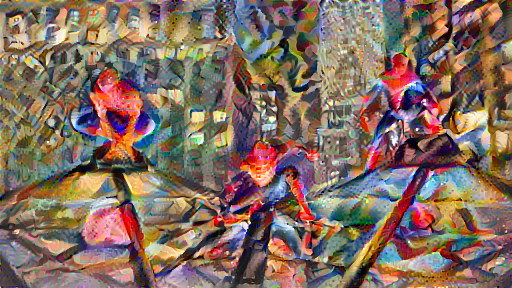

Train step: 1000
Total time: 187.5


In [36]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

- Finally, save the result:

In [37]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<a name=section6></a>

---
# **6. Conclusion**
---

- Using two different methods, we were able to **apply style transfer** to our image.

- The **fast style transfer** can be used for arbitrary styles and images and is the go-to for quick style transfers.

- But more is possible through the **optimization technique** which takes more time but gives a great insight to the approach of style transfer.

- Feel free to try your **own images** and **styles** to create art!

<a name=section7></a>

---
# **7. Applications**
---

- CNN, transfer learning, and style tranfer could be very useful in various applications.

- We can use **MobileNetV2** with **TFLite** to implement the style transfer in **mobile devices** with ARM processors.

- Apps like **Prisma** have been using neural style transfer in their apps to provide good filters for images.

- Style transfer can also be used for **text style transfer** (for handwriting), for **hairstyle swaps**, etc.

- **Generative Adversial Networks (GANs)** can also be used for a more advanced level of style transfer.
